In [0]:
%load_ext autoreload
%matplotlib inline

In [0]:
#Import required libraries
%autoreload 2
!pip3 install --upgrade pip
!pip3 install torch
!pip3 install torchvision
!pip3 install torchfusion
!pip3 install tensorboardx
!pip3 install pillow
!pip3 install pydicom
!pip3 install opencv-python
!pip3 install -q keras==2.2.4
!pip3 install --upgrade keras.utils
#!pip3 install --upgrade tensorflow-gpu

import os
import errno
import scipy
import pydicom as dicom
import scipy.misc
import numpy as np
import tqdm
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow import nn, layers
from tensorflow.contrib import layers as clayers 

import keras
import keras.backend as K
from keras.layers.core import Dropout, Lambda, Dense, Flatten
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import Add
from keras.layers import Input, Activation, Flatten, ZeroPadding2D
from keras.models import Model
from keras.optimizers import Adam
from keras.engine import InputSpec
from keras.engine.topology import Layer
from keras.utils import conv_utils

import torch
import torch.cuda as cuda
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal

import torchvision.utils as vutils
from torchvision import transforms, utils, datasets

from torchfusion.gan.learners import *
from torchfusion.gan.applications import StandardGenerator,StandardProjectionDiscriminator
from torchfusion.datasets import mnist_loader

from tensorboardX import SummaryWriter
from IPython import display

from PIL import Image

from getpass import getpass

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.0.1)
    100% |████████████████████████████████| 2.0MB 10.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


    100% |████████████████████████████████| 71kB 3.3MB/s 
    100% |████████████████████████████████| 1.4MB 15.4MB/s 
    100% |████████████████████████████████| 133kB 32.0MB/s 
    100% |████████████████████████████████| 204kB 27.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/ee/87/ce/a5023722374ca73b57fc8d4284ba6f973c01219b3c385a07e0
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile
    100% |████████████████████████████████| 7.0MB 6.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/46/25/27/7707005c1cb27e1ffc8277b004ac295e34767b02b44d73d6be
Successfully built keras.utils


Using TensorFlow backend.


In [0]:
class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(128, 128))
        #plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        #plt.axis('off')
        #if plot_horizontal:
            #display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        #plt.close()

        # Save squared
        fig = plt.figure()
        #plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        #plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        #plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise
                

[autoreload of PIL.Image failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'py3'
]
[autoreload of PIL._binary failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'py3'
]


In [0]:
class OASISDataset(Dataset):
          
    def __init__(self, arr_name = "T1_DCM", transforms=None):
        
        self.transforms = transforms
        self.FLAIR_DCM = []
        self.ROI_DCM = []
        self.T1_DCM = []
        self.T2_DCM = []
        self.data = torch.zeros(()).new_empty((22, 1, 512, 512))
        
        #get OASIS Data from private BitBucket (since the data is not available publicly)
        
        user = getpass('BitBucket user')
        password = getpass('BitBucket password')
        os.environ['BITBUCKET_AUTH'] = user + ':' + password.replace("@", "%40")

        !git clone https://$BITBUCKET_AUTH@bitbucket.org/sidijju/OASIS-Data.git
        os.chdir("OASIS-Data/")
        
        #Floydhub: 
        #root = "/floyd/home/OASIS-Data/BRAINIX/DICOM/"
        
        #Colaboratory:
        root = "/content/OASIS-Data/BRAINIX/DICOM/"

        #read in data
        for dirName, subdirList, fileList in os.walk("/content/OASIS-Data/BRAINIX/DICOM/"):
            if(dirName == root + "FLAIR"):
                for filename in fileList:
                    self.FLAIR_DCM.append(os.path.join(dirName,filename))
            if(dirName == root + "ROI"):
                for filename in fileList:
                    self.ROI_DCM.append(os.path.join(dirName,filename))
            if(dirName == root + "T1"):
                for filename in fileList:
                    self.T1_DCM.append(os.path.join(dirName,filename))
            if(dirName == root + "T2"):
                for filename in fileList:
                    self.T2_DCM.append(os.path.join(dirName,filename))

        #self.FLAIR_Ref = self.getInfo(self.FLAIR_DCM)
        #self.FLAIR_Dicom = np.zeros(self.FLAIR_Ref[1], dtype=self.FLAIR_Ref[0].pixel_array.dtype)
        #self.storeList(self.FLAIR_DCM, self.FLAIR_Dicom)

        #self.ROI_Ref = self.getInfo(self.ROI_DCM)
        #self.ROI_Dicom = np.zeros(self.ROI_Ref[1], dtype=self.ROI_Ref[0].pixel_array.dtype)
        #self.storeList(self.ROI_DCM, self.ROI_Dicom)
        
        #store T1 data
        
        self.T1_Ref = self.getInfo(self.T1_DCM)
        self.T1_Dicom = np.zeros(self.T1_Ref[1], dtype=self.T1_Ref[0].pixel_array.dtype)
        self.storeList(self.T1_DCM, self.T1_Dicom)

        #self.T2_Ref = self.getInfo(self.T2_DCM)
        #self.T2_Dicom = np.zeros(self.T2_Ref[1], dtype=self.T2_Ref[0].pixel_array.dtype)
        #self.storeList(self.T2_DCM, self.T2_Dicom)
        
        if(arr_name == "T1_DCM"):
            self.arr = self.T1_Dicom.reshape((22, 1, 512, 512))
        elif(arr_name == "T2_DCM"):
            self.arr = self.T2_Dicom
        elif(arr_name == "FLAIR_DCM"):
            self.arr = self.FLAIR_Dicom
        else:
            self.arr = self.ROI_Dicom 
        
    def getInfo(self, ref):
      
          # Get ref file
        RefDs = dicom.read_file(ref[0])

          # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
        ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(ref))
          # Load spacing values (in mm)
        ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
          #calculate axes
        x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
        y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
        z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])
        
        return (RefDs, ConstPixelDims, ConstPixelSpacing, x, y, z)

    def storeList(self, directory, array):
        for filenameDCM in directory:
            ds = dicom.read_file(filenameDCM)
            array[:, :, int(filenameDCM[-6:-4]) - 1] = ds.pixel_array
            
    def plotPicture(self, im, ref, title=""):
        #plot picture of data
        plt.figure(dpi=50)
        plt.axes().set_aspect('equal', 'datalim')
        plt.set_cmap(plt.gray())
        plt.title(title)
        plt.pcolormesh(self.T1_Ref[3], self.T1_Ref[4], im)

    def __getitem__(self, index):
        if index < np.size(self.arr,0) and index >= 0:
            if self.transforms is not None:
                self.plotPicture(self.T1_Dicom[index].reshape((512, 512)), self.T1_Ref, "Picture " + str(index))
                self.data.add(self.transforms(self.arr[index].astype('uint8')))
            return self.arr[index].astype('uint8'), index
        else:
            print("INDEX INVALID")
            return None
        
    def __len__(self):
        return np.size(self.arr,0)
      

In [0]:
#load custom dataset with torch

image_shape = (512, 512, 1)

DATA_FOLDER = './tf_data/MRIGAN/OASIS'
def oasis_data():
    compose = transforms.Compose(
        [
            transforms.ToTensor(),
            #transforms.Normalize((.5, .5, .5), (.5, .5, .5)),
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return OASISDataset(arr_name = "T1_DCM", transforms = compose)

##Define Different Types of Blocks

---
We will use two types of blocks in this GAN. 

###Resnet Block


---
The Resnet block consists of two convolution and activation layers, along with a direct connection between the input and the output layer. This serves to allow more information from the original image to flow through in the neural network.

![Diagram of Resnet Block](https://cdn-images-1.medium.com/max/1200/1*ByrVJspW-TefwlH7OLxNkg.png)


In [0]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation("relu")(x)
    return x

def res_block(input, filters, kernel_size = (3,3), strides=(1,1), use_dropout=False):
    x = Activation("relu")(input)
    x = BatchNormalization()(x)
    x = convolution_block(x, filters, kernel_size )
    x = convolution_block(x, filters, kernel_size, activation=False)
    x = Add()([x, input])
    return x

##Define the Generator and the Discriminator

---

### Generator


---

The Generator model will take in an input of an aliased MRI image and output a de-aliased one. Its goal is to increase its chances of fooling the discriminator into thinking that it's producing the actual real image. 


In [0]:
#Number of filters
ngf = 64

#Input and Output number of channels
input_nc = 1
output_nc = 1

#Input Shape of the Generator
input_shape_generator = (512, 512, input_nc)

#Number of Resnet Blocks
n_blocks_gen = 9

def generator_model():

    inputs = Input(shape=input_shape_generator)
    x = Conv2D(filters=ngf, kernel_size=(7,7), padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Increase filter number
    n_downsampling = 2
    for i in range(n_downsampling):
        mult = 2**i
        x = Conv2D(filters=ngf*mult*2, kernel_size=(3,3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # Apply 9 ResNet blocks
    mult = 2**n_downsampling
    for i in range(n_blocks_gen):
        x = res_block(x, ngf*mult, use_dropout=True)

    # Decrease filter number
    for i in range(n_downsampling):
        mult = 2**(n_downsampling - i)
        x = Conv2DTranspose(filters=int(ngf*mult/2), kernel_size=(3,3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = ZeroPadding2D((2, 2))(x)
    x = Conv2D(filters=output_nc, kernel_size=(7,7), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    
    # Add direct connection from input to output and recenter to [-1, 1]
    
    outputs = Add()([x, inputs])
    outputs = Lambda(lambda z: z/2)(outputs)

    model = Model(inputs=inputs, outputs=outputs, name='Generator')
    return model

### Discriminator


---

The Discriminator determines whether the output of the Generator is a real MRI image or whether it is "fake". Its goal is to be able to tell apart generated images from real ones.

In [0]:
#Number of filters
ndf = 64

#Number of output channels
output_nc = 1

#Input Shape of Image to the Discriminator
input_shape_discriminator = (512, 512, output_nc)


def discriminator_model():
    n_layers, use_sigmoid = 3, False
    inputs = Input(shape=input_shape_discriminator)

    x = Conv2D(filters=ndf, kernel_size=(4,4), strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)

    nf_mult, nf_mult_prev = 1, 1
    for n in range(n_layers):
        nf_mult_prev, nf_mult = nf_mult, min(2**n, 8)
        x = Conv2D(filters=ndf*nf_mult, kernel_size=(4,4), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    nf_mult_prev, nf_mult = nf_mult, min(2**n_layers, 8)
    x = Conv2D(filters=ndf*nf_mult, kernel_size=(4,4), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(filters=1, kernel_size=(4,4), strides=1, padding='same')(x)
    if use_sigmoid:
        x = Activation('sigmoid')(x)

    x = Flatten()(x)
    x = Dense(1024, activation='tanh')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x, name='Discriminator')
    return model

## Putting It all Together


---

In this segment we combine the generator and discriminator models and define losses for each of them. Since this model has to have the generated images be as close to the real ones as possible, we have to have the outputs of the generated images in the final model.

In [0]:
def gendis_mult_out(generator, discriminator):
    inputs = Input(shape=(512, 512, 1))
    generated_images = generator(inputs)
    outputs = discriminator(generated_images)
    model = Model(inputs=inputs, outputs=[generated_images, outputs])
    return model

### Losses


---

We will use multiple losses in the model. 
#### Wasserstein Loss


---


Wasserstein Loss is similar to Mean Squared Error in that it finds the mean of the differences between two images. It is known to improve GAN performance.

In [0]:
def w_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

####Perceptual Loss


---

Perceptual Loss uses the classic VGG16 architecture to determine similarity between images.

In [0]:
from keras.applications.vgg16 import VGG16

def perceptual_loss(y_true, y_pred):
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(512, 512, 3))
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    loss_model.trainable = False
    y_true = K.concatenate((y_true, y_true, y_true), axis = 3)
    y_pred = K.concatenate((y_pred, y_pred, y_pred), axis = 3)
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

## Training the Model


---

We have now arrived at the final step of the GAN: defining the dataset and training the model. 

### Dataset


---

We will load in the OASIS Dataset using the custom class defined above. Since OASIS data is not public, I used a Bitbucket login to access the data and pull it into this notebook. This notebook will not work without that data. 

We will also define a method of removing information from the images in order to get aliased MRI images. This data will be x_train. 

The real images themselves will be y_train.

In [0]:
from scipy import fftpack

def plot_fft(im, fig):
    plt.grid(False)
    plt.imshow(np.abs(im), norm=LogNorm(vmin=5))

In [0]:
dataset = oasis_data()

BitBucket user··········
BitBucket password··········
Cloning into 'OASIS-Data'...
remote: Counting objects: 119, done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 119 (delta 28), reused 119 (delta 28)
Receiving objects: 100% (119/119), 189.42 MiB | 32.53 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Checking out files: 100% (102/102), done.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part


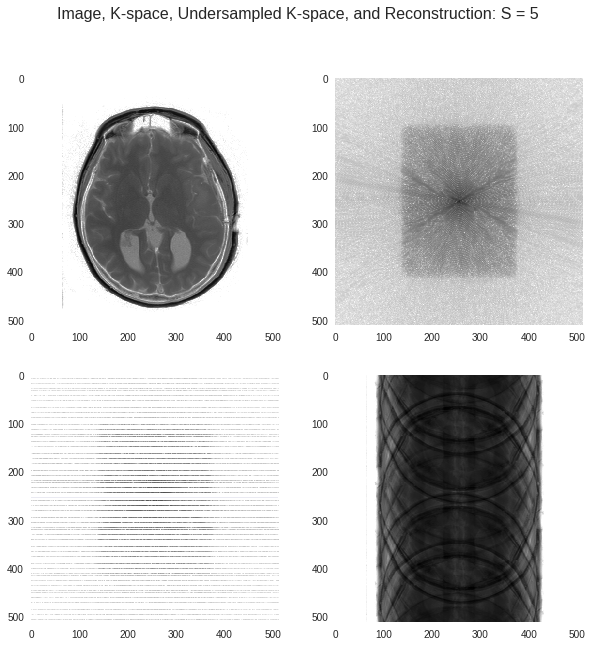

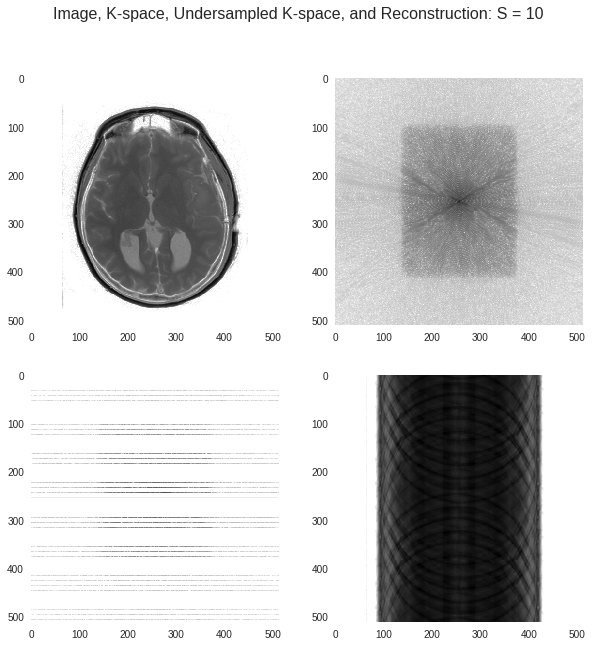

(<tf.Tensor 'ExpandDims_18:0' shape=(22, 512, 512, 1) dtype=float64>,
 <tf.Tensor 'ExpandDims_19:0' shape=(22, 512, 512, 1) dtype=uint16>)

In [0]:
from matplotlib.colors import LogNorm

def process_img(im, display = False, sampling_rate = 2, title = "Image, K-space, Undersampled K-space, and Reconstruction"):
  
  #sample original k-space image
  im_fft = fftpack.fft2(im)
  im_recon = fftpack.ifft2(im_fft)

  im_sampled = np.zeros((512, 512))
  for i in range(512//sampling_rate):
    im_sampled[sampling_rate*i] = im_fft[sampling_rate*i]
    for j in range(1, sampling_rate):
      im_sampled[sampling_rate*i+j] = np.ones((1, 512))

  im_recon_sampled = fftpack.ifft2(im_sampled)
  
  # Now shift the quadrants around so that low spatial frequencies are in
  # the center of the 2D fourier transformed image.
  im_fft2 = fftpack.fftshift(im_fft)
  im_sampled2 = fftpack.fftshift(im_sampled)
    
  if display is True:
    ### Display Image Data ###  
    fig = plt.figure(figsize = (10, 10))
    fig.suptitle(title, fontsize = 16)
    fig.add_subplot(221)
    plot_fft(im_recon, fig)
    fig.add_subplot(222)
    plot_fft(im_fft2, fig)
    fig.add_subplot(223)
    plot_fft(im_sampled2, fig)
    fig.add_subplot(224)
    plot_fft(im_recon_sampled, fig)
    plt.show()
    
  return im_recon_sampled

def get_data_simple(dataset, title = "Image, K-space, Undersampled K-space, and Reconstruction: S = 2" , sampling_rate = 2, display = False):
  
  y = np.rollaxis(dataset.T1_Dicom, 2)
  x = np.empty((y.shape[0], 512, 512))

  for i in range(y.shape[0]):
    x[i] = process_img(y[i], sampling_rate)
    
  process_img(y[11], display, sampling_rate, title)
  
  x = K.expand_dims(x, axis = -1)
  y = K.expand_dims(y, axis = -1)
  
  return x, y
        
get_data_simple(dataset, True)
get_data_simple(dataset, "Image, K-space, Undersampled K-space, and Reconstruction: S = 5", 5, True)
get_data_simple(dataset, "Image, K-space, Undersampled K-space, and Reconstruction: S = 10", 10, True)

### Models and Optimizers


---

Here we will initialize the Generator and Discriminator models and also define the optimizers for each. 

In [0]:
# Initialize models
g = generator_model()
print("GENERATOR")
g.summary()

d = discriminator_model()
print("DISCRIMINATOR")
d.summary()

d_on_g = gendis_mult_out(g, d)

# Initialize optimizers
g_opt = Adam(epsilon=1e-08)
d_opt = Adam(epsilon=1e-08)
d_on_g_opt = Adam(epsilon=1e-08)


GENERATOR
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 506, 506, 64) 3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 506, 506, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 506, 506, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________


### Compiling and Training

---

In this last step, we will compile our models with the losses we defined and train them. 

In [0]:
# Compile models
d.trainable = True
d.compile(optimizer=d_opt, loss=w_loss)
d.trainable = False
loss = [perceptual_loss, w_loss]
loss_weights = [100, 1]
d_on_g.compile(optimizer=d_on_g_opt, loss=loss, loss_weights=loss_weights)
d.trainable = True

58892288/58889256 [==============================] - 1s 0us/step


Now we will process and define the batches of images.

In [0]:
def save_all_weights(d, g, epoch_number, current_loss):
    now = datetime.datetime.now()
    save_dir = os.path.join("weights/", '{}{}'.format(now.month, now.day))
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    g.save_weights(os.path.join(save_dir, 'generator_{}_{}.h5'.format(epoch_number, current_loss)), True)
    d.save_weights(os.path.join(save_dir, 'discriminator_{}.h5'.format(epoch_number)), True)

In [0]:
EPOCH_NUM = 50

BATCH_SIZE = 11

output_true_batch, output_false_batch = np.ones((BATCH_SIZE, 1)), -np.ones((BATCH_SIZE, 1))

logger = Logger(model_name='MRIGAN', data_name='OASIS')

x_train, y_train = get_data_simple(dataset)

def get_batch(indices, data):
  
  batch = data[indices[0]]
  batch = K.expand_dims(batch, axis = 0)
  for index in indices:
    if index != indices[0]:
      batch = K.concatenate((batch, K.expand_dims(data[index], axis = 0)), axis = 0)
  print(batch.shape)
  return batch
        

for epoch in tqdm.tqdm(range(EPOCH_NUM)):
    
    num_samples = int(x_train.shape[0])
    
    permutated_indexes = np.random.permutation(num_samples)
    num_batches = int(num_samples / BATCH_SIZE)

    d_losses = []
    d_on_g_losses = []
    for n_batch in range(num_batches):
        batch_indexes = permutated_indexes[n_batch*BATCH_SIZE:(n_batch+1)*BATCH_SIZE]
        
        sampled_batch = get_batch(batch_indexes, x_train)
        print(sampled_batch.shape)
        full_batch = get_batch(batch_indexes, y_train)

        generated_images = g.predict(x=sampled_batch, steps = 1)

        for _ in range(5):
            d_loss_real = d.train_on_batch(full_batch, output_true_batch)
            d_loss_fake = d.train_on_batch(generated_images, output_false_batch)
            d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
            d_losses.append(d_loss)

        d.trainable = False

        d_on_g_loss = d_on_g.train_on_batch(sampled_batch, [full_batch, output_true_batch])
        d_on_g_losses.append(d_on_g_loss)

        d.trainable = True
    
        logger.display_status(epoch, d_on_g_loss, d_loss)
        logger.log_images(generated_images, 4, i, n_batch, num_batches, format='NHWC');        
        logger.log(d_loss, d_on_g_loss, epoch, n_batch, num_batches)    
        
    print(np.mean(d_losses), np.mean(d_on_g_losses))
    with open('log.txt', 'a+') as f:
        f.write('{} - {} - {}\n'.format(epoch, np.mean(d_losses), np.mean(d_on_g_losses)))

    save_all_weights(d, g, epoch, int(np.mean(d_on_g_losses)))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part



  0%|          | 0/50 [00:00<?, ?it/s]

(11, 512, 512, 1)
(11, 512, 512, 1)
(11, 512, 512, 1)


ResourceExhaustedError: ignored